# Tynan 548 Project File



### Init Libaries and Dynamics

In [11]:

import cvxpy as cp # import cvxpy

# in this problem, we will use the dynamaxsys library to import dynamical systems implemented in JAX: https://github.com/UW-CTRL/dynamaxsys
from dynamaxsys.simplecar import DynamicallyExtendedSimpleCar
from dynamaxsys.base import get_discrete_time_dynamics
from dynamaxsys.utils import linearize


import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import ipywidgets as widgets
from IPython.display import display, clear_output
import numpy as np
import functools
from ipywidgets import interact


In [12]:
# define the robot dynamics
wheelbase = 1.0
dt = 0.1
ct_robot_dynamics = DynamicallyExtendedSimpleCar(wheelbase=wheelbase) # robot dynamics
dt_robot_dynamics = get_discrete_time_dynamics(ct_robot_dynamics, dt=dt) # discrete time dynamics
state_dim = dt_robot_dynamics.state_dim
control_dim = dt_robot_dynamics.control_dim

### Dynamics and goals

In [13]:
# set up the problem parameters
planning_horizon = 20 # 20 # length of the planning horizon
num_time_steps = 150 # number of time steps to simulate
num_sqp_iterations = 15 # 15 # number of SQP iterations
t = 0. # this doesn't affect anything, but a value is needed 

# control and velocity limits
v_max = 2.5 #2 m/s
v_min = 0.05 # 0.2 m/s
acceleration_max = 3.0 #2/-2  m/s/s
acceleration_min = -3.0 # m/s/s
steering_max = 2. #started 0.5/-0.5 # radians/sec
steering_min = -2. # radians/sec

# obstacle parameters

robot_radius = 0.1 # robot radius
goal_locations = [jnp.array([6.11, 1.44]), jnp.array([5.87, 1.19]), jnp.array([6.29, 0.84]), jnp.array([7.33, 0.15]), jnp.array([7.44, 3.35]), jnp.array([8.2, 7.6]), 
                jnp.array([0.87, 6.25]), jnp.array([0.20, 4.68]), jnp.array([-0.13, 5.23]), jnp.array([0.17, 4.77]), jnp.array([0.83, 6.18]), jnp.array([-2.28, 8.40])]
goal_location = goal_locations[0]
goal_radius = 0.15



### Defining Classes

In [14]:
## Establish Rectangle Class ## 

class Rectangle:
    def __init__(self, center, length, width, buffer=0.15): # 0.4 # 0.25 buffer makes robot go narrow way
        """
        Initialize a rectangular obstacle.

        Args:
            center (tuple or jnp.ndarray): (x, y) coordinates of the center.
            length (float): Length along the x-axis.
            width (float): Width along the y-axis.
            buffer (float): Optional buffer space for inflation.
        """
        self.center = jnp.array(center)
        self.length = length
        self.width = width
        self.buffer = buffer

    def inflated_half_lengths(self):
        return (self.length / 2 + self.buffer, self.width / 2 + self.buffer)

    def as_array(self):
        """Returns center and dimensions as a single array."""
        return jnp.array([*self.center, self.length, self.width, self.buffer])

    def __repr__(self):
        return f"Rectangle(center={self.center.tolist()}, l={self.length}, w={self.width}, buffer={self.buffer})"



## Establish Circle Class ## 

class Circle:
    def __init__(self, center, radius, buffer=0.2): # 0.4 # 0.25 buffer makes robot go narrow way
        """
        Initialize a circular obstacle.

        Args:
            center (tuple or jnp.ndarray): (x, y) coordinates of the center.
            radius (float)
            buffer (float): Optional buffer space for inflation.
        """
        self.center = jnp.array(center)
        self.radius = radius
        self.buffer = buffer

    def as_array(self):
        """Returns center and dimensions as a single array."""
        return jnp.array([*self.center, self.radius, self.buffer])

    def __repr__(self):
        return f"Circle(center={self.center.tolist()}, buffer={self.buffer})"








### Defining Obstacles

In [ ]:
### Init Constraint Objects


## Rectangle Obstacles
rectangles = [
    #Rectangle(center=(0.2, 6.0), length=0.6, width=0.6),
    #Rectangle(center=(-0.2, 6.4), length=0.6, width=0.6),
    Rectangle(center=(4.0, 2.0), length=0.5, width=0.5)
]

## Circle caps for rectangle obstacles
circles = [
    Circle(center=(6.8, 2.2), radius=0.8),
    Circle(center=(6.0, 3.6), radius=1.2),
    Circle(center=(6.9, 5.8), radius=1.7),
    Circle(center=(7.1, 4.0), radius=0.3),
    Circle(center=(4.7, 4.3), radius=1.6),
    Circle(center=(2.8, 8.9), radius=2.2),
    Circle(center=(0.3, 5.8), radius=0.35),
    Circle(center=(0.0, 6.3), radius=0.35),    
    Circle(center=(-0.3, 6.8), radius=0.35), # breaking?
    Circle(center=(-0.55, 7.2), radius=0.35),
    Circle(center=(-0.8, 7.7), radius=0.35),
    Circle(center=(-1.4, 7.2), radius=1.0), 
    Circle(center=(2.0, 2.6), radius=0.8) #no
]

## Background circles, not part of calculation
circ_bg = []


## Rectangle CBF ##
CBF_object = Rectangle(center=(3.0,4.5), length=14.0, width=9.0) #boundary robot stays within


### Helper Functions

In [16]:
# HELPER FUNCTIONS #

# define obstacle function g(x) >= 0
# where g(x) is the distance from the obstacle
@jax.jit
def circle_constraint(state, obstacle, radius, buffer):
    return jnp.linalg.norm(state[:2] - obstacle[:2]) - radius - buffer


def smooth_max(a, b, alpha=5.0):
    return (1/alpha) * jnp.log(jnp.exp(alpha * a) + jnp.exp(alpha * b))

@jax.jit
def rect_constraint_smooth(state, obstacle, l, w, buffer, alpha=5.0):
    dx = jnp.abs(state[0] - obstacle[0]) - l / 2 - buffer
    dy = jnp.abs(state[1] - obstacle[1]) - w / 2 - buffer
    return smooth_max(dx, dy, alpha=alpha)

# define goal function g(x) >= 0
# where g(x) is the distance from the goal

@jax.jit
def goal_constraint(state, goal, radius):
    return jnp.linalg.norm(state[:2] - goal[:2]) - radius


# function to simulate the discrete time dynamics given initial state and control sequence
@functools.partial(jax.jit, static_argnames=["dt_dynamics"])
def simulate_discrete_time_dynamics(dt_dynamics, state, controls, t0, dt):
    states = [state]
    t = t0
    for c in controls:

        state = dt_dynamics(state, c, t)
        states.append(state)
        t += dt
    return jnp.stack(states)

# function to simulate the discrete time dynamics given initial state and control sequence
# function slightly modified to add noise 
@functools.partial(jax.jit, static_argnames=["dt_dynamics"])
def simulate_discrete_time_dynamics_with_noise(dt_dynamics, state, controls, t0, dt, noises):
    states = [state]
    t = t0
    for (c,noise) in zip(controls, noises):
        state = dt_robot_dynamics(state, c, t + noise * dt) # take out noises for now
        states.append(state)
        t += dt
    return jnp.stack(states, -1)

# jit the linearize constraint functions to make it run faster
linearize_circle = jax.jit(jax.vmap(jax.grad(circle_constraint), in_axes=[0, None, None, None]))
linearize_goal = jax.jit(jax.vmap(jax.grad(goal_constraint), in_axes=[0, None, None]))
linearize_rect_smooth = jax.jit(
    jax.vmap(jax.grad(rect_constraint_smooth, argnums=0), in_axes=[0, None, None, None, None])
)

### Problem construction. 

Two things I am missing: a CLF-type function adding stability in converging to goals. Add threshold for distance where robot starts to consider obstacles as part of constraint. Currently, robot sees all obstacles at all times, which can lead to some unpredictable behavior when adjusting objects far away from initial robot position.

In [17]:
# set up cvxpy problem variables and parameters
xs = cp.Variable([planning_horizon+1, state_dim])  # cvx variable for states
us = cp.Variable([planning_horizon, control_dim])  # cvx variable for controls
slack = cp.Variable(1) # slack variable to make sure the problem is feasible
As = [cp.Parameter([state_dim, state_dim]) for _ in range(planning_horizon)]  # parameters for linearized dynamics
Bs = [cp.Parameter([state_dim, control_dim]) for _ in range(planning_horizon)] # parameters for linearized dynamics
Cs = [cp.Parameter([state_dim]) for _ in range(planning_horizon)] # parameters for linearized dynamics


Gs_circs = [[cp.Parameter([state_dim]) for _ in range(planning_horizon + 1)] for _ in range(len(circles))]
hs_circs = [[cp.Parameter(1) for _ in range(planning_horizon + 1)] for _ in range(len(circles))]

#Gs_rects = [[cp.Parameter([state_dim]) for _ in range(planning_horizon + 1)] for _ in range(len(rectangles))]
#hs_rects = [[cp.Parameter(1) for _ in range(planning_horizon + 1)] for _ in range(len(rectangles))]

Gs_CBF = [cp.Parameter([state_dim]) for _ in range(planning_horizon+1)] # parameters for linearized constraints CBF
hs_CBF = [cp.Parameter(1) for _ in range(planning_horizon+1)] # parameters for linearized constraints CBF


Goal_Gs = [cp.Parameter([state_dim]) for _ in range(planning_horizon+1)] # parameters for linearized constraints
Goal_hs = [cp.Parameter(1) for _ in range(planning_horizon+1)] # parameters for linearized constraints

xs_previous = cp.Parameter([planning_horizon+1, state_dim]) # parameter for previous solution
us_previous = cp.Parameter([planning_horizon, control_dim]) # parameter for previous solution
initial_state = cp.Parameter([state_dim]) # parameter for current robot state

### Constraints

In [18]:
# set up cvxpy problem cost and constraints
def construct_problem(goal_location):
    beta1 = 0.2 # coefficient for control effort
    beta2 = 5. # coefficient for progress
    beta3 = 10. # coefficient for trust region
    slack_penalty = 1000. # coefficient for slack variable
    markup = 1.0
    goal_cost_weight = 15. # 10
    forward_velocity_weight = 0.1 # prev 0.1 # encourage robot to keep moving forward
    v_min = 0.0
    proximity_buffer = .7 # prox DISTANCE of robot to obstacles, soft discourage
    proximity_weight = 3.
    turning_penalty = 3.0


    # Discourages large changes in state and control
    objective = beta3 * (cp.sum_squares(xs - xs_previous) + cp.sum_squares(us - us_previous)) + slack_penalty * slack**2

    constraints = [xs[0] == initial_state, slack >= 0] # initial state and slack constraint
    for t in range(planning_horizon):
        objective += (beta1 * cp.sum_squares(us[t]) ) * markup**t # only penalizes control effort
        #terminal_goal_dist_sq = cp.sum_squares(xs[planning_horizon, :2] - goal_location) * markup**t
        #objective += terminal_goal_weight * terminal_goal_dist_sq


            # Encourage steady progress toward the goal
        step_goal_dist_sq = cp.sum_squares(xs[t, :2] - goal_location)
        objective += goal_cost_weight * step_goal_dist_sq * markup**t
        objective += -forward_velocity_weight * cp.sum(xs[:, 2]) * markup # encourages movement

        constraints += [xs[t+1] == As[t] @ xs[t] + Bs[t] @ us[t] + Cs[t]] # dynamics constraint
        constraints += [xs[t,-1] <= v_max, xs[t,-1] >= v_min, us[t,1] <= acceleration_max, us[t,1] >= acceleration_min, us[t,0] <= steering_max, us[t,0] >= steering_min] # control and velocity limit constraints
        
        # Penalize sharp changes in direction
        heading_diff = xs[t+1, 2] - xs[t, 2]
        objective += turning_penalty * cp.sum_squares(heading_diff)

        # Soft penalize going close to obstacles
        #for r_idx in range(len(Gs_rects)):
        #    constraints += [Gs_rects[r_idx][t] @ xs[t] + hs_rects[r_idx][t] >= 0]
        #    dist = Gs_rects[r_idx][t] @ xs[t] + hs_rects[r_idx][t]
        #    # Penalty if within 1m of obstacle edge: (1 - dist)^2 if dist < 1
        #    objective += proximity_weight * cp.pos(proximity_buffer - dist)**2

        for r_idx in range(len(Gs_circs)):
            constraints += [Gs_circs[r_idx][t] @ xs[t] + hs_circs[r_idx][t] >= 0]
            dist = Gs_circs[r_idx][t] @ xs[t] + hs_circs[r_idx][t]
            # Penalty if within 1m of obstacle edge: (1 - dist)^2 if dist < 1
            objective += proximity_weight * cp.pos(proximity_buffer - dist)**3

        # Robot only sees obstacles if they are within a certain distance
        for r_idx in range(len(Gs_circs)):
            # Estimate distance from previous state
            robot_pos = xs_previous[t, :2].value if xs_previous[t, :2].value is not None else np.zeros(2)
            obstacle_center = circles[r_idx].center  # You need this list of centers
            distance = np.linalg.norm(robot_pos - obstacle_center)

            if distance < 6.0: # set vision distance, has to be greater than largest object diameter + buffer
                # Only add constraints and penalties if within range
                # This significantly decreases compiling time
                constraints += [Gs_circs[r_idx][t] @ xs[t] + hs_circs[r_idx][t] >= 0]
                dist = Gs_circs[r_idx][t] @ xs[t] + hs_circs[r_idx][t]
                objective += proximity_weight * cp.pos(proximity_buffer - dist)**3


        # CBF, rectangle allowable traversable range
        constraints += [Gs_CBF[t] @ xs[t] + hs_CBF[t] <= 0]

    #####
    constraints += [xs[planning_horizon,-1] <= v_max, xs[planning_horizon,-1] >= v_min] #,
                #Gs[planning_horizon] @ xs[planning_horizon] + hs[planning_horizon] >= -slack]

    # Process rectangular obstacles final timestep
    #for r_idx in range(len(Gs_rects)):
    #    constraints += [Gs_rects[r_idx][planning_horizon] @ xs[planning_horizon] + hs_rects[r_idx][planning_horizon] >= -slack]

    # Process circular obstacles final timestep
    for r_idx in range(len(Gs_circs)):
        constraints += [Gs_circs[r_idx][planning_horizon] @ xs[planning_horizon] + hs_circs[r_idx][planning_horizon] >= 0]

    return cp.Problem(cp.Minimize(objective), constraints) # construct problem
    

### Running Simulation

In [19]:
# initial states
robot_state = jnp.array([goal_locations[0][0], goal_locations[0][1], 0., 1.])  # robot starting state 92.38, 0.0977

robot_trajectory = [robot_state] # list to collect robot's state as it replans
sqp_list = [] # list to collect each sqp iteration 
robot_control_list = []  # list to collect robot's constrols as it replans
robot_trajectory_list = [] # list to collect robot's planned trajectories

# initial robot planned state and controls
previous_controls = jnp.zeros([planning_horizon, control_dim]) # initial guess for robot controls
previous_states =  simulate_discrete_time_dynamics(dt_robot_dynamics, robot_state, previous_controls, 0., dt) # initial guess for robot states
xs_previous.value = np.array(previous_states) # set xs_previous parameter value
us_previous.value = np.array(previous_controls) # set us_previous parameter value 

# precompute the noise
key = jax.random.PRNGKey(0)
noise_covar = jnp.diag(jnp.array([0.1, 0.1, 0.05, 0.2])) # noise covariance
noises = jax.random.multivariate_normal(key, jnp.zeros(robot_state.shape), noise_covar, shape=(num_time_steps,))

In [ ]:
prob = construct_problem(goal_location)
goal_index = 0
#for t in range(num_time_steps):
t = 0
while goal_index < len(goal_locations): #iterate through until reached end goal
    goal_threshold = 0.20  # set working at 0.20
    distance_to_goal = np.linalg.norm(robot_state[:2] - goal_location)
    if distance_to_goal < goal_threshold:
        if goal_index < len(goal_locations) - 1: #stop resetting goal after last goal reached
            goal_location = goal_locations[goal_index + 1]
            print(f"Point {goal_index} sampled at sol {t}. Searching for Point {goal_index + 1} at {goal_location}.")
            goal_index += 1
                    
        else:
            print(f"Point {goal_index} sampled at sol {t}. All goals reached!")
            break

        # Reset velocity
        #robot_state = robot_state.at[-1].set(0)

        # Reorient toward next goal
        #robot_control[:] = 0
        delta = goal_location - robot_state[:2]
        new_heading = np.arctan2(delta[1], delta[0])
        robot_state = robot_state.at[2].set(new_heading)

        prob = construct_problem(goal_location)  # rebuild with new goal
        solver = cp.CLARABEL

        previous_states = np.tile(np.array(robot_state), (planning_horizon + 1, 1))
        previous_controls = np.zeros((planning_horizon, control_dim))
    t += 1 # 
    
    initial_state.value = np.array(robot_state)
    sqp_solutions = [previous_states]

    
    for i in range(num_sqp_iterations):
        #print("goal location in sqp loop:", goal_location)
        As_value, Bs_value, Cs_value = jax.vmap(linearize, in_axes=[None, 0, 0, None])(dt_robot_dynamics, previous_states[:-1], previous_controls, 0.)
        #Gs_value = linearize_obstacle(previous_states, obstacle_location, obstacle_radius + robot_radius) 
        #hs_value = jax.vmap(obstacle_constraint, [0, None, None])(previous_states, obstacle_location, obstacle_radius + robot_radius) - jax.vmap(jnp.dot, [0, 0])(Gs_value, previous_states)
    
        # Init vectors for batch rectangle and circle obstacles
        #Gs_rects_values = []
        #hs_rects_values = []
        Gs_circs_values = []
        hs_circs_values = []

        #for rect in rectangles:
        #    G_val = linearize_rect_smooth(previous_states, rect.center, rect.length, rect.width, rect.buffer)
        #    h_val = (
        #        jax.vmap(rect_constraint_smooth, [0, None, None, None, None])(previous_states, rect.center, rect.length, rect.width, rect.buffer)
        #        - jax.vmap(jnp.dot, [0, 0])(G_val, previous_states)
        #    )
        #    Gs_rects_values.append(G_val)
        #    hs_rects_values.append(h_val)

        for circ in circles:
            G_val = linearize_circle(previous_states, circ.center, circ.radius, circ.buffer)
            h_val = (
                jax.vmap(circle_constraint, [0, None, None, None])(previous_states, circ.center, circ.radius, circ.buffer)
                - jax.vmap(jnp.dot, [0, 0])(G_val, previous_states)
            )
            Gs_circs_values.append(G_val)
            hs_circs_values.append(h_val)


        Gs_CBF_value = linearize_rect_smooth(previous_states, CBF_object.center, CBF_object.length, CBF_object.width, CBF_object.buffer)
        hs_CBF_value = (
                jax.vmap(rect_constraint_smooth, [0, None, None, None, None])(previous_states, CBF_object.center, CBF_object.length, CBF_object.width, CBF_object.buffer)
                - jax.vmap(jnp.dot, [0, 0])(Gs_CBF_value, previous_states))


        Goal_Gs_value = linearize_goal(previous_states, goal_location, goal_radius + robot_radius) 
        Goal_hs_value = jax.vmap(goal_constraint, [0, None, None])(previous_states, goal_location, goal_radius + robot_radius) - jax.vmap(jnp.dot, [0, 0])(Goal_Gs_value, previous_states)

        for i in range(planning_horizon):
            As[i].value = np.array(As_value[i])
            Bs[i].value = np.array(Bs_value[i])
            Cs[i].value = np.array(Cs_value[i])

            Goal_Gs[i].value = np.array(Goal_Gs_value[i])
            Goal_hs[i].value = np.array(Goal_hs_value[i:i+1])

                # Handle all rectangle and circle constraints
            #for r_idx in range(len(rectangles)):
            #    Gs_rects[r_idx][i].value = np.array(Gs_rects_values[r_idx][i])
            #    hs_rects[r_idx][i].value = np.array(hs_rects_values[r_idx][i:i+1])

            for r_idx in range(len(circles)):
                Gs_circs[r_idx][i].value = np.array(Gs_circs_values[r_idx][i])
                hs_circs[r_idx][i].value = np.array(hs_circs_values[r_idx][i:i+1])

            Gs_CBF[i].value = np.array(Gs_CBF_value[i])
            hs_CBF[i].value = np.array(hs_CBF_value[i:i+1])


        Goal_Gs[planning_horizon].value = np.array(Goal_Gs_value[planning_horizon])
        Goal_hs[planning_horizon].value = np.array(Goal_hs_value[planning_horizon:planning_horizon+1])

        #for r_idx in range(len(rectangles)):
        #    Gs_rects[r_idx][planning_horizon].value = np.array(Gs_rects_values[r_idx][planning_horizon])
        #    hs_rects[r_idx][planning_horizon].value = np.array(hs_rects_values[r_idx][planning_horizon:planning_horizon+1])

        for r_idx in range(len(circles)):
            Gs_circs[r_idx][planning_horizon].value = np.array(Gs_circs_values[r_idx][planning_horizon])
            hs_circs[r_idx][planning_horizon].value = np.array(hs_circs_values[r_idx][planning_horizon:planning_horizon+1])

        Gs_CBF[planning_horizon].value = np.array(Gs_CBF_value[planning_horizon])
        hs_CBF[planning_horizon].value = np.array(hs_CBF_value[planning_horizon:planning_horizon+1])


        result = prob.solve(
            solver=cp.CLARABEL,
        )

        if us.value is None:
            #print("No solution found")
            break

        previous_controls = us.value
        previous_states =  simulate_discrete_time_dynamics(dt_robot_dynamics, robot_state, previous_controls, 0., dt)
        sqp_solutions.append(previous_states)
        xs_previous.value = np.array(previous_states)
        us_previous.value = np.array(previous_controls)

    sqp_list.append(np.stack(sqp_solutions))
    robot_control = previous_controls[0]
    robot_control_list.append(robot_control)
    
    # get the robot next state using the control input
    robot_state = dt_robot_dynamics(robot_state, robot_control, noises[t] * dt) 
    
    # clipping the robot velocity so the problem doesn't become infeasible at the next step
    robot_state = robot_state.at[3].set(jnp.clip(robot_state[3], v_min, v_max)) 
    
    # add robot state and trajectory to the list
    robot_trajectory.append(robot_state)
    robot_trajectory_list.append(previous_states)
    
    # update the previous states and controls for the next iteration
    previous_states =  simulate_discrete_time_dynamics(dt_robot_dynamics, robot_state, previous_controls, 0., dt)

robot_trajectory = jnp.stack(robot_trajectory)
robot_controls = jnp.stack(robot_control_list)

Point 0 sampled at sol 0. Searching for Point 1 at [5.87 1.19].
Point 1 sampled at sol 2. Searching for Point 2 at [6.29 0.84].
Point 2 sampled at sol 7. Searching for Point 3 at [7.33 0.15].
Point 3 sampled at sol 16. Searching for Point 4 at [7.44 3.35].


c:\Users\ariel\anaconda3\envs\ME548\Lib\site-packages\cvxpy\problems\problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Point 4 sampled at sol 34. Searching for Point 5 at [8.2 7.6].
Point 5 sampled at sol 194. Searching for Point 6 at [0.87 6.25].


### Plotting


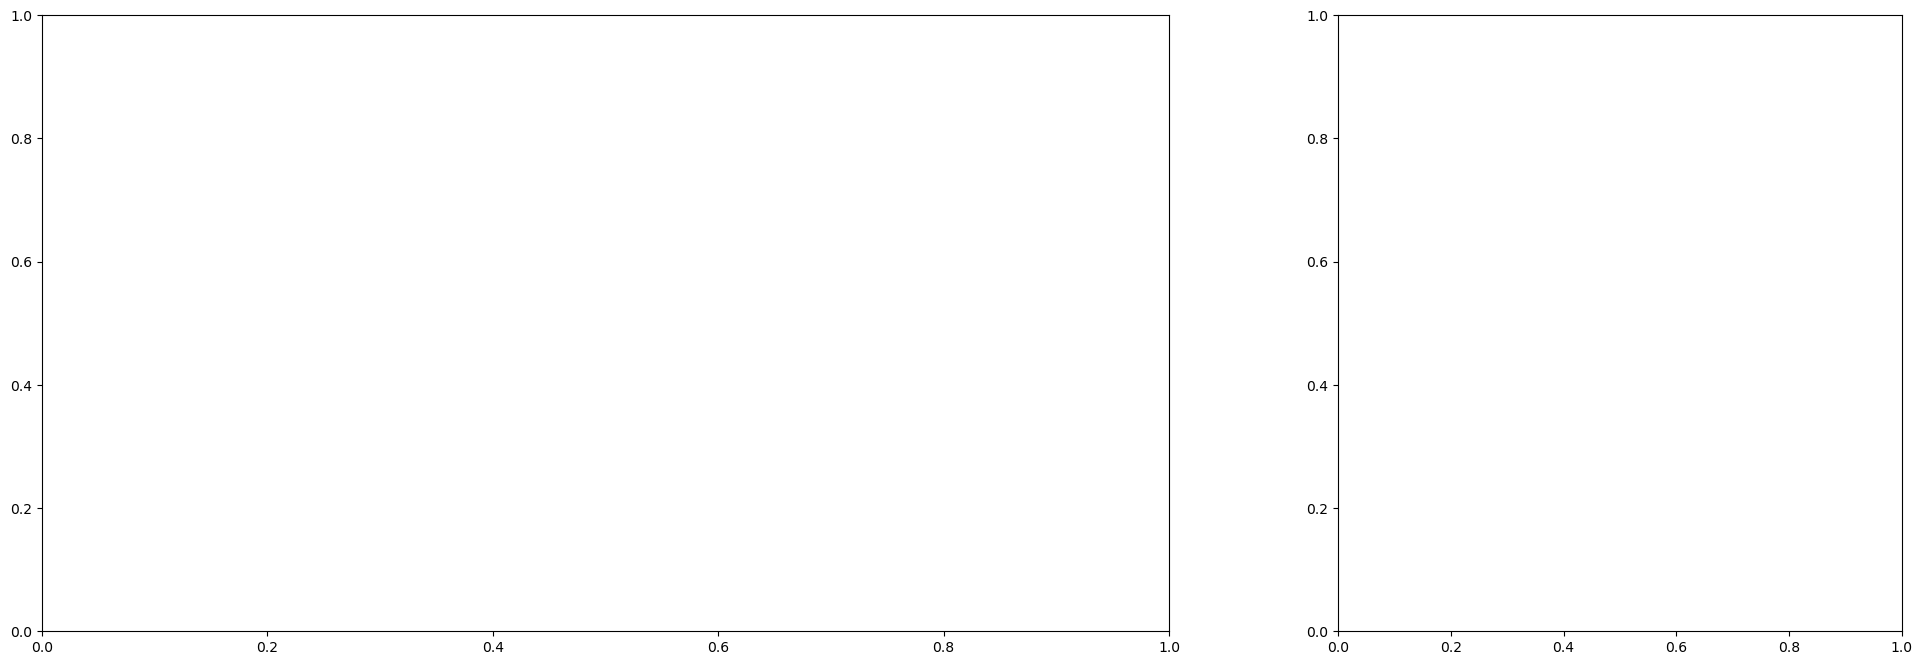

interactive(children=(IntSlider(value=71, description='i', max=142), IntSlider(value=7, description='j', max=1…

In [ ]:
# plotting the results. No need to add comments here. Just run this cell to visualize the results
@interact(i=(0,t-1), j=(0,num_sqp_iterations-1))

def plot(i, j):
    fig, axs = plt.subplots(1, 2, figsize=(24, 8), gridspec_kw={'width_ratios': [2, 1]})
    # fig, axs = plt.subplots(1,2, figsize=(10, 4))
    ax = axs[0]
    robot_position = robot_trajectory[i, :2]
    circle1 = plt.Circle(robot_position, robot_radius, color='C0', alpha=1.0)
    #circle2 = plt.Circle(obstacle_location, obstacle_radius, color='C1', alpha=0.4)
    #circle3 = plt.Circle(obstacle_location2, obstacle_radius, color='C1', alpha=0.4)
    
    # plot goals
    for count in range(0, len(goal_locations)):
        ax.add_patch(plt.Circle(goal_locations[count], goal_radius, color='C2', alpha=0.6))
                
        # Add goal index label at the center
        ax.text(
            goal_locations[count][0],                # x-coordinate
            goal_locations[count][1],                # y-coordinate
            str(count),                                 # text to display
            color='black',                              # text color
            fontsize=10,                                # size of the number
            ha='center',                                # horizontal alignment
            va='center',                                # vertical alignment
            fontweight='bold'
        )
    
    for count in range(0, len(rectangles)):
        bottom_left = rectangles[count].center - jnp.array([rectangles[count].length / 2, rectangles[count].width / 2])
        rect_plot = patches.Rectangle(
            bottom_left,
            rectangles[count].length,            # length along x
            rectangles[count].width,            # width along y
            linewidth=1,
            edgecolor='#b04a00',
            facecolor='#b04a00',
            alpha=1.0
        )
        ax.add_patch(rect_plot)

        # Add rectangle index label at the center
        ax.text(
            rectangles[count].center[0],                # x-coordinate
            rectangles[count].center[1],                # y-coordinate
            str( ''),                                 # text to display
            color='black',                              # text color
            fontsize=10,                                # size of the number
            ha='center',                                # horizontal alignment
            va='center',                                # vertical alignment
            fontweight='bold'
        )

    for count in range(0, len(circles)):
        circ_plot = patches.Circle(circles[count].center, circles[count].radius, color='#b04a00', alpha=1.0)
        ax.add_patch(circ_plot)
        # Add rectangle index label at the center
        ax.text(
            circles[count].center[0],                # x-coordinate
            circles[count].center[1],                # y-coordinate
            str(''),                                 # text to display
            color='black',                              # text color
            fontsize=10,                                # size of the number
            ha='center',                                # horizontal alignment
            va='center',                                # vertical alignment
            fontweight='bold'
        )

    # Plot CBF object
    bottom_left = CBF_object.center - jnp.array([CBF_object.length / 2, CBF_object.width / 2])
    rect_plot = patches.Rectangle(
        bottom_left,
        CBF_object.length,            # length along x
        CBF_object.width,            # width along y
        linewidth=1,
        edgecolor='C2',
        facecolor='#b04a00',
        alpha=0.25
    )
    ax.add_patch(rect_plot)

    ax.plot(robot_trajectory[:,0], robot_trajectory[:,1], "o-", markersize=1, color='grey')
    ax.plot(robot_trajectory_list[i][:,0], robot_trajectory_list[i][:,1], "o-", markersize=3, color='red', label="Planned")
    # Plot planned trajectory for the selected SQP iteration

    #planned_trajectory = sqp_list[i][j]

    if i < len(sqp_list) and j < len(sqp_list[i]):
        planned_trajectory = sqp_list[i][j]
        ax.plot(planned_trajectory[:, 0], planned_trajectory[:, 1], "o-", markersize=3, color='green', alpha=0.4, label=f"SQP iteration {j}")
    else:
        ax.text(0.5, 0.5, f"No SQP {j} at step {i}", transform=ax.transAxes, ha='center', va='center', fontsize=12, color='red')

    #ax.plot(planned_trajectory[:, 0], planned_trajectory[:, 1], "o-", markersize=3, color='green', alpha=0.4, label="SQP iteration %d" % j)
    ax.scatter(robot_trajectory[i:i+1,0], robot_trajectory[i:i+1,1], s=30,  color='C100', label="Robot")
   
    x_center, y_center = CBF_object.center
    half_length = CBF_object.length / 2
    half_width = CBF_object.width / 2

    ax.set_xlim([x_center - half_length, x_center + half_length])
    ax.set_ylim([y_center - half_width, y_center + half_width])
    #ax.axis("equal")
    
    ax.legend()

    ax.set_title("heading=%.2f velocity=%.2f"%(robot_trajectory[i,2], robot_trajectory[i,3]))
    
    x_center = float(CBF_object.center[0])
    y_center = float(CBF_object.center[1])
    half_length = float(CBF_object.length) / 2
    half_width = float(CBF_object.width) / 2

    ax.set_xlim(x_center - half_length, x_center + half_length)
    ax.set_ylim(y_center - half_width, y_center + half_width)
    ax.set_aspect('equal')


    ax = axs[1]
    ax.plot(robot_controls)
    ax.scatter([i], robot_controls[i:i+1, 0], label="$tan(\\delta)$", color='C0')
    ax.scatter([i], robot_controls[i:i+1, 1], label="Acceleration", color='C1')

    ax.hlines(steering_min, 0, t-1, color='C0', linestyle='--')
    ax.hlines(steering_max, 0, t-1, color='C0', linestyle='--')
    ax.hlines(acceleration_min, 0, t-1, color='C1', linestyle='--')
    ax.hlines(acceleration_max, 0, t-1, color='C1', linestyle='--')
    
    ax.plot(robot_trajectory[:,-1], markersize=3, color='C2')
    ax.scatter([i], robot_trajectory[i:i+1, 3], label="Velocity", color='C2')
    ax.hlines(v_min, 0, t-1, color='C2', linestyle='--')
    ax.hlines(v_max, 0, t-1, color='C2', linestyle='--')
    ax.set_xlim([0, t])
    ax.set_ylim([-3, 3])
    ax.set_xlabel("Time step")
    ax.set_ylabel("Control")
    ax.set_title("Velocity, steering and acceleration")
    ax.legend()
    ax.grid()

